### НИЯУ МИФИ. Лаботаторная работа #5. Полищук Максим, Б20-505

# Используемая система

```
CPU: 6-core 12th Gen Intel Core i5-12400F (-MCP-) speed: 2496 MHz
Kernel: 5.15.0-50-generic x86_64 Up: 45m Mem: 3491.6/9937.1 MiB (35.1%)
Storage: 71.31 GiB (20.1% used) Procs: 292 Shell: Zsh inxi: 3.3.13

MPI:
HYDRA build details:
    Version:                                 4.0
    Release Date:                            Fri Jan 21 10:42:29 CST 2022
```

**Сложность алгоритма - O(n/p)**

n - количество элементов массива

p - количество потоков

```mermaid
    graph TD
        %%{ init : {"flowchart" : { "curve" : "stepAfter", "diagramPadding": 20 }}}%%
        A(Начало) --> B(i: 0 -> n)
        
        B --> C{"array[i] > max"}
        B --> E(Выход)
        C -->|Да| D["max = array[i]"]
        C -->|Нет| B
        D --> B
       
```

# Код
```
#include <stdlib.h>
#include <stdio.h>
#include <mpi.h>

#define MROWS 100

int main(int argc, char** argv)
{
	int ret  = -1;	///< For return values
	int size = -1;	///< Total number of processors
	int rank = -1;	///< This processor's number

	const int count = 1e1; ///< Number of array elements
	// printf("DEFAULT VALUE - %d\n\n", DEBUG);
	const int random_seed = 1488; ///< RNG seed

	int* array = 0; ///< The array we need to find the max in
	int lmax = -1;	///< Local maximums
	int  max = -1;  ///< The maximal element

	double end, start;

	// * GENERATE TRACEFILE
    char filename[50];
    sprintf(filename, "trace.txt");
    FILE *fp = fopen(filename, "a");
    if (fp == NULL) {
        printf("Can't open file\n");
        exit(1);
    }

	/* Initialize the MPI */
	ret = MPI_Init(&argc, &argv);
	if (!rank) { printf("MPI Init returned (%d);\n", ret); }

	/* Determine our rankand processor count */
	MPI_Comm_size(MPI_COMM_WORLD, &size);
	// printf("MPI Comm Size: %d;\n", size);
	MPI_Comm_rank(MPI_COMM_WORLD, &rank);
	// printf("MPI Comm Rank: %d;\n", rank);

	/* Allocate the array */
	array = (int*)malloc(count * sizeof(int));

	// ! Master generates the array */
	if (!rank) {
		/* Initialize the RNG */
		srand(RANDOM_SEED);
		/* Generate the random array */
		for (int i = 0; i < count; i++) { array[i] = rand(); }
	}

	start = MPI_Wtime();

	//printf("Processor #%d has array: ", rank);
	//for (int i = 0; i < count; i++) { printf("%d ", array[i]); }
	//printf("\n");

	/* Send the array to all other processors */
	MPI_Bcast(array, count, MPI_INTEGER, 0, MPI_COMM_WORLD);

	// printf("Processor #%d has array: ", rank);
	// for (int i = 0; i < count; i++) { printf("%d ", array[i]); }
	// printf("\n");

	const int wstart = (rank    ) * count / size;
	const int wend   = (rank + 1) * count / size;

	// printf("Processor #%d checks items %d .. %d;\n", rank, wstart, wend - 1);

	for (int i = wstart;
		i < wend;
		i++)
	{
		if (array[i] > lmax) { lmax = array[i]; }
	}

	// printf("Processor #%d reports local max = %d;\n", rank, lmax);

	MPI_Reduce(&lmax, &max, 1, MPI_INTEGER, MPI_MAX, 0, MPI_COMM_WORLD);

	end = MPI_Wtime();
	ret = MPI_Finalize();
	// if (!rank) { 
	// 	printf("*** Global Maximum is %d;\n", max);
	// }

	fprintf(fp, "%lf;", end-start);
	// printf("MPI Finalize returned (%d);\n", ret);

	return(0);
}
```

In [26]:
# REFACTOR DEFAULT VALUES FOR YOUR SYSTEM
CORE_LIMIT = 12
OLD_CUT = 10
NEW_CUT = 10

In [27]:
# import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_theme(style="darkgrid")

old_arr, cur_arr = [], []

with open("old_trace.txt", "r") as fd:
    for _ in range(CORE_LIMIT):
        line = list(map(float, fd.readline()[:-2].split(";")))
        line = sorted(line)[OLD_CUT:-OLD_CUT]
        avg_value = (sum(line) / len(line))
        old_arr.append(avg_value)
with open("trace.txt", "r") as fd:
    for i in range(CORE_LIMIT):
        line = list(map(float, fd.readline()[:-2].split(";")[::(i+1)]))
        line = sorted(line)[NEW_CUT:-NEW_CUT]
        avg_value = (sum(line) / len(line))
        cur_arr.append(avg_value)

In [37]:
for old, cur in zip(old_arr, cur_arr):
    print("{} - {}, delta - {}".format(round(old, 4), round(cur, 4), round(old-cur, 4)))

0.0163 - 0.0119, delta - 0.0043
0.0086 - 0.0672, delta - -0.0586
0.0058 - 0.0957, delta - -0.0899
0.0047 - 0.1089, delta - -0.1042
0.0038 - 0.1202, delta - -0.1163
0.0032 - 0.1297, delta - -0.1265
0.0026 - 0.1374, delta - -0.1348
0.0028 - 0.1398, delta - -0.137
0.0026 - 0.1501, delta - -0.1475
0.0024 - 0.1601, delta - -0.1577
0.0022 - 0.1709, delta - -0.1687
0.0021 - 0.178, delta - -0.176


In [45]:
# Create DataFrames
old_predf = [[index+1, avg_time, "OpenMP"] for index, avg_time in enumerate(old_arr)]
cur_predf = [[index+1, avg_time, "MPI"] for index, avg_time in enumerate(cur_arr)]
old_df = pd.DataFrame(old_predf, columns=["Threads", "Time", "Type"])
cur_df = pd.DataFrame(cur_predf, columns=["Threads", "Time", "Type"])

all_df = pd.concat([old_df, cur_df])
# all_df

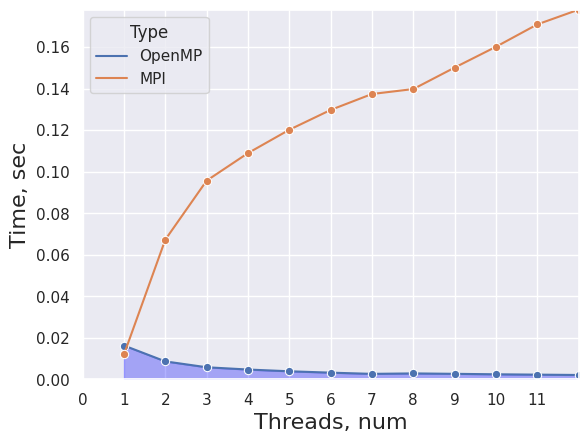

In [47]:
# Time(Thread) graph
p = sns.lineplot(x="Threads", y="Time", hue="Type", marker="o", data=all_df)
p.set_xlabel("Threads, num", fontsize = 16)
p.set_ylabel("Time, sec", fontsize = 16)
l1 = p.lines[0]

x1 = l1.get_xydata()[:, 0]
y1 = l1.get_xydata()[:, 1]
_ = p.fill_between(x1, y1, color="blue", alpha=0.3)
p.margins(x=0, y=0)
_ = p.set_xticks(range(0, CORE_LIMIT))
_ = p.set_xticklabels([str(i) for  i in range(CORE_LIMIT)])


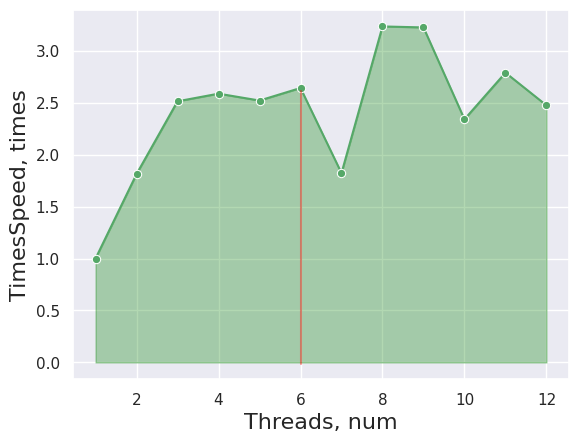

In [54]:
accceleration = [0] * 12
for i in range(0, len(accceleration)):
    accceleration[i] = [saved[i][0], saved[0][1]/saved[i][1]]
a_df = pd.DataFrame(accceleration, columns=["Threads", "TimesSpeed"])
p = sns.lineplot(x="Threads", y="TimesSpeed", marker="o", data=a_df, color='g')
p.set_xlabel("Threads, num", fontsize = 16)
p.set_ylabel("TimesSpeed, times", fontsize = 16)
l1 = p.lines[0]

x1 = l1.get_xydata()[:, 0]
y1 = l1.get_xydata()[:, 1]

_ = p.fill_between(x1, y1, color="green", alpha=0.3)
_ = p.axvline(x=6, ymin=0.04, ymax=0.78, color="red", alpha=0.4)

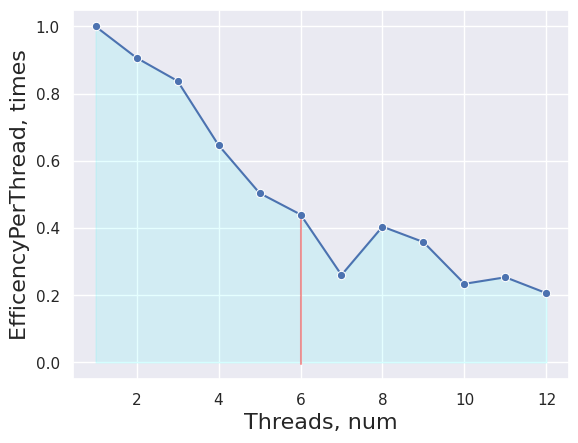

In [58]:
per_thread = [0] * 12
for i in range(0, len(per_thread)):
    per_thread[i] = [accceleration[i][0], accceleration[i][1]/accceleration[i][0]]
thr_df = pd.DataFrame(per_thread, columns=["Threads", "EfficencyPerThread"])
p = sns.lineplot(x="Threads", y="EfficencyPerThread", marker="o", data=thr_df, color='b')
p.set_xlabel("Threads, num", fontsize = 16)
p.set_ylabel("EfficencyPerThread, times", fontsize = 16)
l1 = p.lines[0]

x1 = l1.get_xydata()[:, 0]
y1 = l1.get_xydata()[:, 1]

_ = p.fill_between(x1, y1, color="cyan", alpha=0.1)
_ = p.axvline(x=6, ymin=0.04, ymax=0.43, color="red", alpha=0.4)

## Заключение

В этой работе с использованием **OpenMP** в языке программирования **C** было проведено исследование эффективности многопоточности алгоритма поиска максимального элемента массива.
На машине было 6 реальных ядер, которые задествовала программа, а последующие являются виртуальными

**Вывод:**
- Реальный прирост от количества потоков далёк от рассчётного
- Эффектиность виртальных потоков сильно падает по сравнению с реальными => целесообразность их использования под сомнением.